# DCGAN (Deep Convolutional Generative Adversarial Network) with CelebA Dataset

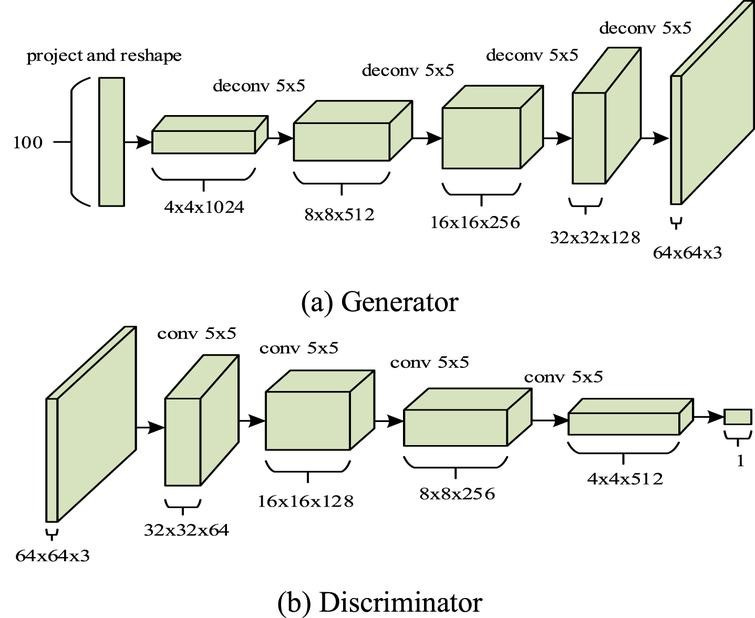

In [ ]:
# Kütüphaneler

import tensorflow as tf
import keras
import numpy as np
import os
import matplotlib.pyplot as plt
import imageio
import glob

from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Dense, Flatten, Reshape, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

from tqdm import tqdm
from IPython.display import Image
from IPython import display

In [ ]:
# Önişleme metotu

def preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [64, 64])
    img = (img / 255.0) * 2.0 - 1.0
    return img

"""
preprocess metotu dosya yolundan alınan resmi tensora dönüştürür, float32 türüne çevirir, yeniden boyutlandırır ve
[-1, 1] aralığında normalize eder.
"""

'\npreprocess metotu dosya yolundan alınan resmi tensora dönüştürür, float32 türüne çevirir, yeniden boyutlandırır ve\n[-1, 1] aralığında normalize eder.\n'

In [ ]:
# Sabitler

batch_size = 32
"""
Eğitimde kullanılacak her bir veri kümesinin boyutunu belirtir.
"""


num_features = 100
"""
Generator'da giriş olarak kullanılacak rastgele vektörün boyutunu belirtir. Jeneratörün oluşturacağı varyasyonların ve karmaşıklığın miktarını belirler.
"""


epochs = 30
"""
Eğitimde kullanılacak olan epok sayısı
"""

'\nEğitimde kullanılacak olan epok sayısı\n'

In [ ]:
# Veri setinin yüklenmesi ve hazırlanması

img_folder = '/content/drive/MyDrive/MyProjects/DCGAN/celebA/images' # Görsellerin bulunduğu klasörün yolu

dataset = tf.data.Dataset.list_files(img_folder + '/*.jpg')

dataset = dataset.map(lambda x: preprocess_image(x), num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.shuffle(10000)

dataset = dataset.batch(batch_size, drop_remainder=True)

dataset = dataset.prefetch(1)

"""
Dosya yolundan tüm görseller listelenir her birisi preprocess işlemine tutlur ve tensor biçiminde kaydedilir.

shuffle(buffer_size=10000):
  Burada, buffer (arabellek) boyutu 10,000 olarak belirlenmiştir.
Bu, veri kümesinin 10,000 elemanlık bir buffer'da karıştırılacağı anlamına gelir.
Karıştırma, modelin veri kümesinin belirli bir sıralamadan etkilenmeden öğrenmesini sağlar.

batch(batch_size=32, drop_remainder=True):
  Bu işlem, veri kümesindeki öğeleri topluca işler. Yani, batch_size kadar öğe bir araya getirilir ve
her bir batch (toplu) halinde modelin eğitimine sunulur. Burada, batch boyutu 32 olarak belirlenmiştir.
Yani, her seferinde 32 öğe işlenir. drop_remainder=True olduğunda, eksik öğeleri içeren son batch atılır.
Bu, her batch'in tam batch_size kadar öğe içermesini sağlar.

prefetch(1): Bu işlem, veri kümesinin eğitim sırasında daha hızlı işlenmesini sağlar.
prefetch ile, veri kümesinin gelecekteki batch'leri önceden yüklenir, böylece eğitim sırasında veri yükleme ve
işleme gecikmeleri minimize edilir. buffer_size=1 olarak belirlenmiştir, yani bir sonraki batch önceden yüklenir.
Bu, eğitim sürecinin daha akıcı ve hızlı olmasına yardımcı olur.
"""

"\nDosya yolundan tüm görseller listelenir her birisi preprocess işlemine tutlur ve tensor biçiminde kaydedilir.\n\nshuffle(buffer_size=10000):\n  Burada, buffer (arabellek) boyutu 10,000 olarak belirlenmiştir.\nBu, veri kümesinin 10,000 elemanlık bir buffer'da karıştırılacağı anlamına gelir.\nKarıştırma, modelin veri kümesinin belirli bir sıralamadan etkilenmeden öğrenmesini sağlar.\n\nbatch(batch_size=32, drop_remainder=True):\n  Bu işlem, veri kümesindeki öğeleri topluca işler. Yani, batch_size kadar öğe bir araya getirilir ve\nher bir batch (toplu) halinde modelin eğitimine sunulur. Burada, batch boyutu 32 olarak belirlenmiştir.\nYani, her seferinde 32 öğe işlenir. drop_remainder=True olduğunda, eksik öğeleri içeren son batch atılır.\nBu, her batch'in tam batch_size kadar öğe içermesini sağlar.\n\nprefetch(1): Bu işlem, veri kümesinin eğitim sırasında daha hızlı işlenmesini sağlar.\nprefetch ile, veri kümesinin gelecekteki batch'leri önceden yüklenir, böylece eğitim sırasında veri 

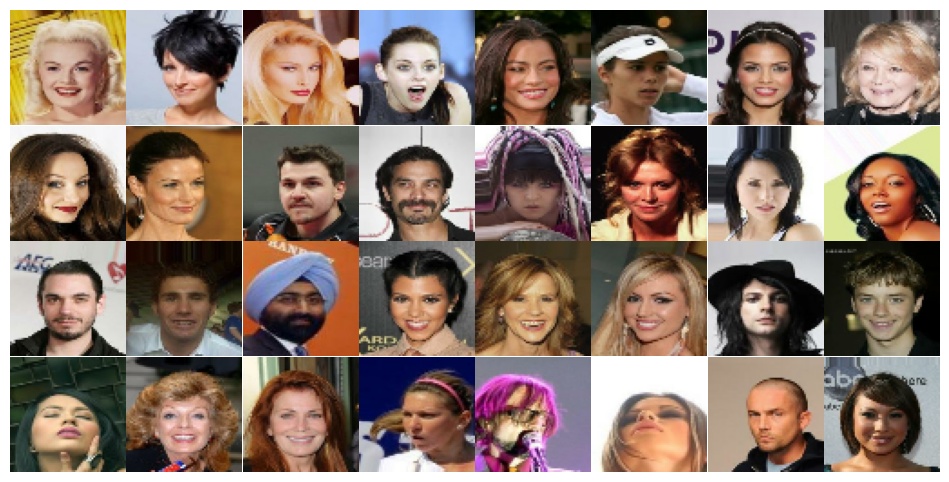

"\nDataset'ten  ilk batch çekilir np array'e dönüştürülür ve batch'in tamamı görselleştirilir.\n"

In [ ]:
batch = next(iter(dataset))
batch = np.array(batch)

plt.figure(figsize=(12, 6))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow((batch[i] + 1.0) / 2.0)
    plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

"""
Dataset'ten  ilk batch çekilir np array'e dönüştürülür ve batch'in tamamı görselleştirilir.
"""

In [ ]:
# Generator
generator = Sequential()

generator.add(Dense((4 * 4 * 1024), input_shape=(num_features,)))
generator.add(Reshape((4, 4, 1024)))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(512, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(negative_slope=0.2))

generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(negative_slope=0.2))

generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(negative_slope=0.2))

generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, activation='tanh', padding='same'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16384)               │       1,654,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 4, 4, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 512)           │      13,107,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 256)         │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 128)         │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 3)           │           9,603 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,876,163 (72.01 MB)

 Trainable params: 18,872,323 (71.99 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [ ]:
# Discriminator
discriminator = Sequential()

discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(64, 64, 3)))
discriminator.add(LeakyReLU(negative_slope=0.2))
discriminator.add(Dropout(0.2))

discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(LeakyReLU(negative_slope=0.2))
discriminator.add(Dropout(0.2))

discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
discriminator.add(LeakyReLU(negative_slope=0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
discriminator.add(LeakyReLU(negative_slope=0.2))
discriminator.add(Dropout(0.4))

discriminator.add(Flatten())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 512)           │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,314,753 (16.46 MB)

 Trainable params: 4,314,753 (16.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Optimizer ve Loss Function

d_optimizer = Adam(learning_rate=0.00005, beta_1=0.5)
g_optimizer = Adam(learning_rate=0.0001, beta_1=0.5)

loss_fn = BinaryCrossentropy()

"""
Discriminator ve generator'da kullanmak için optimizer olarak Adam seçildi.
Loss function olarak BinaryCrossentropy seçildi.
"""

"\nDiscriminator ve generator'da kullanmak için optimizer olarak Adam seçildi.\nLoss function olarak BinaryCrossentropy seçildi.\n"

In [ ]:
seed = tf.random.normal(shape=[batch_size, num_features])
"""
Generator'e her seferinde başlangıç olarak aynı seed'i veriyoruz ve ağırlıklarının güncellenmesiyle bu rastgele gürültüden
nasıl bir yüz oluşturacağını izliyoruz
"""

"\nGenerator'e her seferinde başlangıç olarak aynı seed'i veriyoruz ve ağırlıklarının güncellenmesiyle bu rastgele gürültüden\nnasıl bir yüz oluşturacağını izliyoruz\n"

In [ ]:
def generate_and_save_images(generator, epoch, test_input):

    predictions = generator(test_input, training=False)

    fig = plt.figure(figsize=(10,10))

    for i in range(25):
        plt.subplot(5, 5, i+1)

        img = (predictions[i, :, :, :] + 1.0) / 2.0
        plt.imshow(img)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

"""
Bu metot her epok sonunda ağırlıkları güncellenmiş generator modelin'e rastgele oluşturulan (32, 100) boyutlarındaki vektörü verir
(seed, test_input)), generatör bu vektörü alır ve (32, 64, 64, 3) boyutlarındaki tensoru oluşturur (predictions). Bu
tensor generator'un oluşturduğu 32 adet yapay yüzü ifade eder.
Matplotlib ile bu tensordaki verilerin 25 tanesi denormalizasyon yapılır (Değerler [-1, 1] arasında bu değerler [0, 1] arasına
çekilir yoksa görselleştirme yapılamaz) ve görselleştirilir.

Üretilen 25 resim 5x5'lik biçimde kaydedilir.
"""

"\nBu metot her epok sonunda ağırlıkları güncellenmiş generator modelin'e rastgele oluşturulan (32, 100) boyutlarındaki vektörü verir\n(seed, test_input)), generatör bu vektörü alır ve (32, 64, 64, 3) boyutlarındaki tensoru oluşturur (predictions). Bu\ntensor generator'un oluşturduğu 32 adet yapay yüzü ifade eder.\nMatplotlib ile bu tensordaki verilerin 25 tanesi denormalizasyon yapılır (Değerler [-1, 1] arasında bu değerler [0, 1] arasına\nçekilir yoksa görselleştirme yapılamaz) ve görselleştirilir.\n\nÜretilen 25 resim 5x5'lik biçimde kaydedilir.\n"

In [ ]:
def train_step(real_images):

    noise = tf.random.normal(shape=[batch_size, num_features])  # Rastgele gürültü oluşturulur

    generated_images = generator(noise)  # Gürülütü ile sahte görüntüler oluşturulur

    combined_images = tf.concat([generated_images, real_images], axis=0) # Sahte ve gerçek görüntüler birleştirilir.

    labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)
    # Sahte görüntülere 0, gerçek görüntülere 1 gelecek şekilde etiketler oluşturulur

    labels += 0.05 * tf.random.uniform(tf.shape(labels))
    # Label smoothing yapılarak etiketlere biraz gürültü eklenir bu overfitting'i önler

    with tf.GradientTape() as tape:
        predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))
    """
    Karışık resimler önce ayırıcı'ya gönderilir ve bu resimlere ayırıcının yaptığı tahminler elde edilir daha sonra bu tahminler ve etiketler
    yani gerçek sonuçlar ile loss function'a sokulur ve bir kayıp elde edilir. Bu kayıbın eğitim ağırlıkları üzerindeki gradyanı hesaplanır ve
    bu gradyan modelin ağırlıkları üzerinde uygulanır. Bu şekilde ayırıcının ağırlıkları güncellenir.
    """


    noise = tf.random.normal(shape=[batch_size, num_features]) # Tekrardan rastgele gürültü oluşturulur

    misleading_labels = tf.ones((batch_size, 1)) # Yanıltıcı etiketler oluşturulur

    with tf.GradientTape() as tape:
        predictions = discriminator(generator(noise))
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))

    """
    Üreticiye sahte görüntüler oluşturtulur ve ayrıcı'ya bu görseller verilerek tahmin oluşturulur, bu tahmin değerleri ile sahte etiketler
    kayıp fonksiyonuna verilir. Kayıp fonksiyonu (loss_fn), üreticinin ürettiği sahte görüntülerin ayırıcı tarafından gerçek olarak sınıflandırılması
    için gerekli olan kaybı hesaplar.

    Bu kayıp, sahte verilerin ayırıcı tarafından gerçek olarak sınıflandırılmasını sağlama başarısını ölçer. Kayıp değeri düşükse, üretici oldukça
    gerçekçi görseller üretiyor demektir ve ayırıcı'yı yanıltma başarısı yüksektir.

    Buradan elde edilen kayıp değeri'nin üretici'nin ağırlıkları üzerindeki gradyanı hesaplanır ve bu gradyan üretici modelin ağırlıkları üzerinde
    uygulanır. Bu şekilde üretici'nin ağırlıkları güncellenir.

    Ayırıcının yanıltılması, üreticinin daha iyi sahte veriler üretmesini sağlar.Her eğitim adımında, ayırıcının yanıltılması
    için yapılan optimizasyon, üretici modelinin kalitesini artırır.
    """

    return g_loss, d_loss # Her batch'ten elde edilen kayıp değerleri döndürülür.

In [ ]:
# Üretici ve ayırıcının kayıpları görselleştirilir

def plot_losses(d_losses, g_losses):
    plot_epochs = range(1, len(d_losses) + 1)

    plt.figure(figsize=(8, 6))

    plt.plot(plot_epochs, d_losses, linestyle='-', label='Discriminator Loss', color='blue')
    plt.plot(plot_epochs, g_losses, linestyle='-', label='Generator Loss', color='green')

    plt.title(f"Discriminator and Generator Loss over {epochs} Epochs")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Her epok için loss değerlerini tutacak olan array'ler
d_losses = []
g_losses = []

In [ ]:
def train(dataset, epochs):

    for epoch in tqdm(range(epochs), desc="Training", position=0, leave=True):

        d_losses_epoch = []
        g_losses_epoch = []

        for batch in dataset:
            g_loss, d_loss = train_step(batch)

            d_losses_epoch.append(d_loss) # Her batch'te elde edilen loss değerleri epok loss'unun tutulduğu listeye eklenir
            g_losses_epoch.append(g_loss)

        d_loss_avg = np.mean(d_losses_epoch) # Her epok sonunda o epokta elde edilen loss'ların ortalamasını buluyoruz
        g_loss_avg = np.mean(g_losses_epoch)

        d_losses.append(d_loss_avg) # Her epok sonu loss ortalamaları listelenir
        g_losses.append(g_loss_avg)

        display.clear_output(wait=True) # Eski çıktıyı kaldırır ve yeni çıktıyı ekrana koyar
        generate_and_save_images(generator, epoch + 1, seed) # Her epok sonunda üretici aynı seed ile test edilir ve görüntü kaydedilir

        tqdm.write(f"Epoch {epoch + 1}/{epochs} - Discriminator Loss: {d_loss_avg:.4f} - Generator Loss: {g_loss_avg:.4f}")


    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

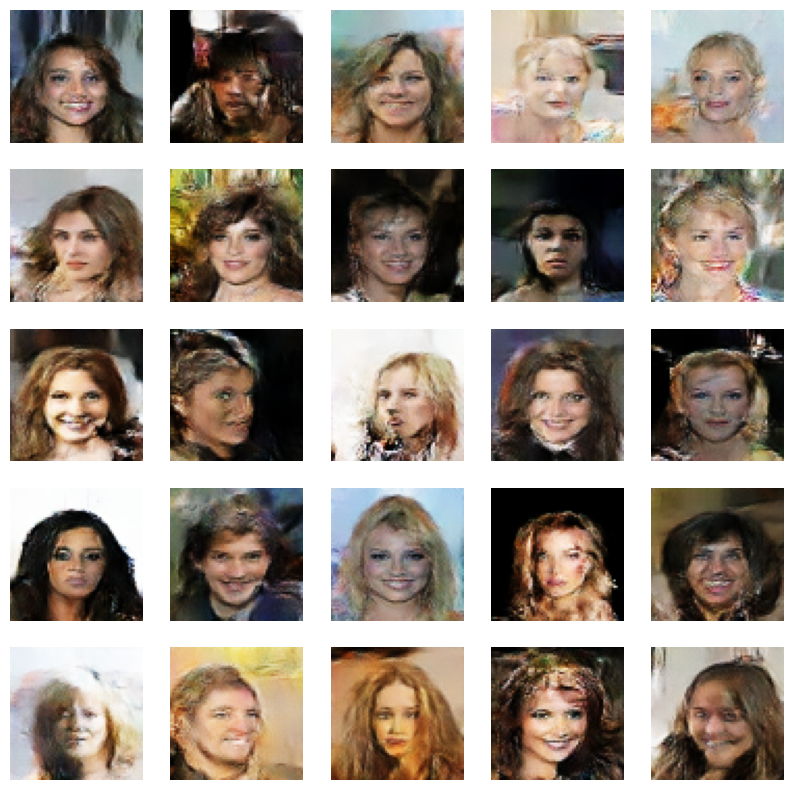

In [ ]:
train(dataset, epochs)

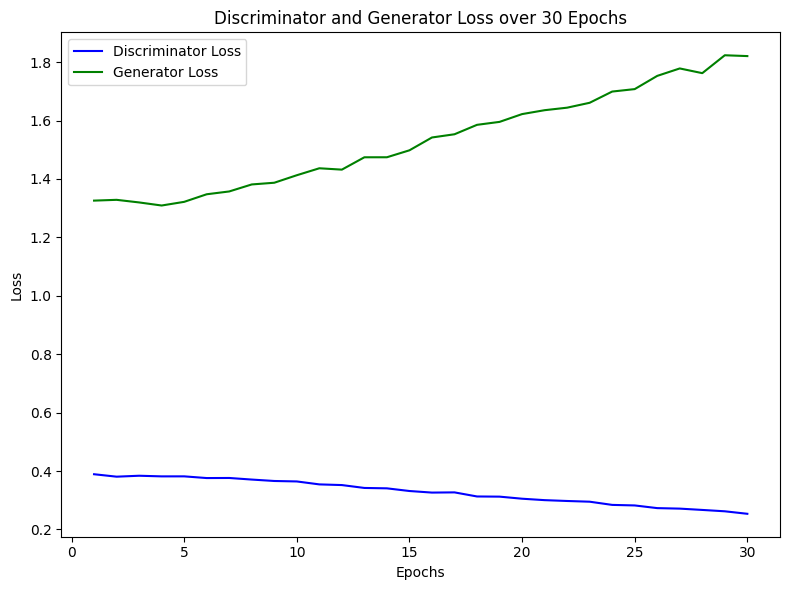

In [ ]:
# Eğitim boyuncaki kayıplar görselleştirilir
plot_losses(d_losses, g_losses)

In [ ]:
# Bu kısımda her epok sonucu elde edilen sonuçlar ile bir gif oluşturulur ve üretilen yüzler'in eğitim sürecindeki durumları takip edilir.

gif_file = 'dcgan.gif'

with imageio.get_writer(gif_file, mode='I', loop=0, duration=1.0) as writer:  # loop=0 sonsuz döngü için
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

from IPython.display import Image
Image(open(gif_file, 'rb').read())

Output hidden; open in https://colab.research.google.com to view.